# Ch. 10 Hands-On Session 

For this hands-on session we will try to have more involvement from the class. You can work in groups. Take your time, explore the different aspects of the problem and the approach and with 10 minutes left each hour we will stop to discuss. Please feel free to ask questions. I have applied all the methods I suggest here so I know they can be done.

# IT MAY BE NECESSARY TO DOWNLOAD THE NEWEST VERSION OF ASTROML

Please go to https://github.com/astroML/astroML and perform the git clone install of the master branch in your local directory for software. Then perform the quick python setup.py install command to continue this exercise. Then all the AstroML commands should work.

### Initialize packages needed for the exercises

These should be all the packages you need to do the exercises, but feel free to use implementations of lomb_scargle or wavelets or whatever from other sources, scipy etc., to see the differences they have on the analysis! 

In [1]:
%matplotlib notebook
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
from astroML.fourier import PSD_continuous
from astroML.time_series import lomb_scargle, multiterm_periodogram, generate_damped_RW
from scipy.signal import cwt, ricker, gausspulse
from scipy import fftpack
from scipy.stats import norm
fignum = 1

## Generate the Data to Use

The following cell contains values which govern the generation of the data for the exercises. Play around with these once you have completed the exercise to see how it affects the analysis method of the time series data.

In [2]:
npr.seed(seed=1000) # set seed so that we have the same data for each group but not explicitly visible

In [3]:
# Initial Values, these you can play with to see what happens to the analysis
num_periodic_terms_even = npr.randint(2,high=8)
npte = num_periodic_terms_even
t_0 = 0.0
delta_t = 10.0
max_time = 3600
noise_level = abs(npr.normal(loc=1,scale=0.125))

In [4]:
dt = delta_t
sampled_data_even = []
sampled_errors_even = []

### Create the evenly sampeled data

In [5]:
even_times = np.arange(t_0,max_time,dt)
Total_time_even = even_times[-1] - even_times[0]
even_periods = npr.uniform(low=2*dt,high=Total_time_even/1.5,size=npte)
even_amplitudes = npr.uniform(low=noise_level, high = npr.randint(1,6)*noise_level,size = npte)

for t in even_times:
    value = 0.0
    for term in np.arange(npte):
            value += even_amplitudes[term]*np.sin(2*np.pi*t/even_periods[term])
            
    sampled_data_even.append(value + npr.normal(loc=0,scale=noise_level)) 
    sampled_errors_even.append(noise_level+ abs(npr.normal(loc=0,scale=noise_level/5)))

<IPython.core.display.Javascript object>


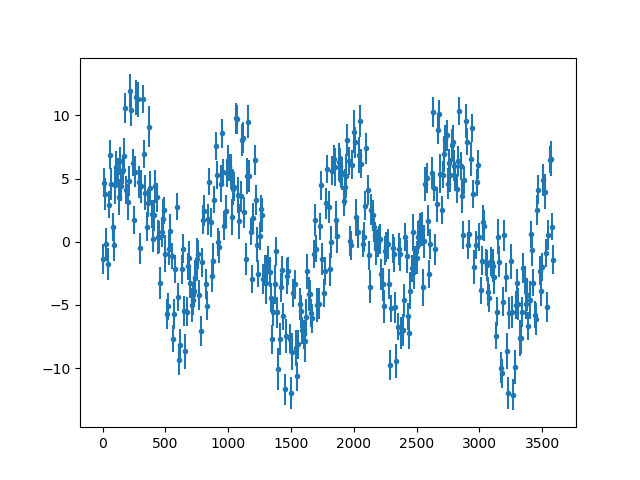

<ErrorbarContainer object of 3 artists>

In [6]:
plt.figure(fignum)
fignum += 1
plt.errorbar(even_times,sampled_data_even,sampled_errors_even,fmt=".")

## Create Pulse Data

In [7]:
sampled_data_pulse = []
sampled_errors_pulse = []

In [8]:
even_times = np.arange(t_0,max_time,dt)
Total_time_even = even_times[-1] - even_times[0]
even_periods = npr.uniform(low=2*dt,high=Total_time_even/1.5,size=1)
even_amplitudes = npr.uniform(low=noise_level, high = npr.randint(1,6)*noise_level,size = 1)

pulse = npr.uniform(low=noise_level, high = npr.randint(1,6)*noise_level,size = 1)*gausspulse(even_times - npr.uniform(1000,3000), fc=0.002)
for i,t in enumerate(even_times):
    value = 0.0
    for term in np.arange(1):
            value += even_amplitudes[term]*np.sin(2*np.pi*t/even_periods[term]) + pulse[i]
            
    sampled_data_pulse.append(value + npr.normal(loc=0,scale=noise_level)) 
    sampled_errors_pulse.append(noise_level+ abs(npr.normal(loc=0,scale=noise_level/5)))

<IPython.core.display.Javascript object>


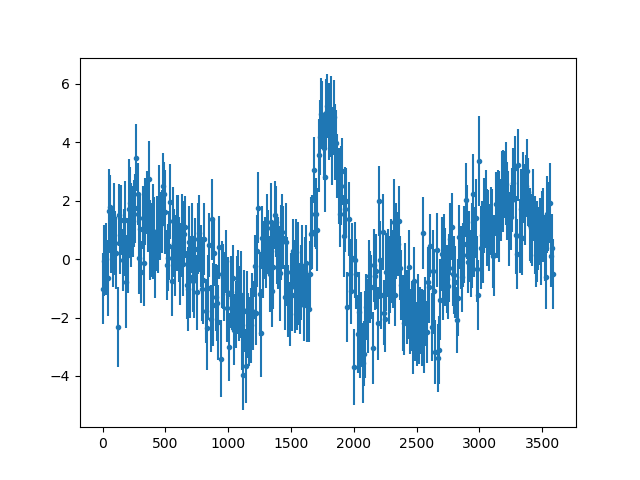

<ErrorbarContainer object of 3 artists>

In [9]:
plt.figure(fignum)
fignum += 1
plt.errorbar(even_times,sampled_data_pulse,sampled_errors_pulse,fmt=".")

## Exercise One: Wavelets vs. Sinusoids


Here we want to use wavelets and sinusoids to try and recover the underlying periods in the evenly sampled data generated above. Particularly it would be intresting to investigate the impact of the noise level and also the localization of events.  It was also be interesting to investigate the breakdown of the application of these methods when the sampling time step becomes larger than the critical time set by the Nyquist frequency.

## Generate the unevenly sampled data

The following cell contains values which govern the generation of the data for the exercises. Play around with these once you have completed the exercise to see how it affects the analysis method of the time series data.

In [13]:
npr.seed(seed=1000) # set seed so that we have the same data for each group but not explicitly visible

In [14]:
# Initial Values, these you can play with to see what happens to the analysis
num_periodic_terms = npr.randint(2,high=8)
npt = num_periodic_terms 
t_0 = 0.0
delta_t = 10.0
max_time = 3600
noise_level = abs(npr.normal(loc=1,scale=0.125))
dt_gaps = np.array([5,40,150])
n_gaps = 3
gap_periods = [200,npr.uniform(300,600),365]
t0_gap = np.array([t_0 + npr.uniform(0,150),t_0 + npr.uniform(0,40), 200])

In [15]:
dt = delta_t
times = [t_0]
sampled_data = []
sampled_errors = []

### Create the unevenly sampled data

In [16]:
time_prev = times[0]
while times[-1]< max_time:
    times.append(time_prev + npr.poisson(lam=dt)) # Use Poisson distribution 
    time_prev = times[-1] 

Total_time = times[-1] - times[0]
periods = npr.uniform(low=5*dt,high=Total_time/3,size=npt)
amplitudes = npr.uniform(low=noise_level, high = npr.randint(1,6)*noise_level+1,size = npt)

# Add gaps to the data sampling (maintenance, moon, orbit)
num_gap_periods = list(map(int,np.floor((Total_time-t0_gap)/gap_periods)))
for i in np.arange(n_gaps):
    for j in np.arange(num_gap_periods[i]):
        times = [t for t in times if t < t0_gap[i] + j*gap_periods[i] or t> t0_gap[i]+j*gap_periods[i] + dt_gaps[i]]

for t in times:
    value = 0.0
    for term in np.arange(npt):
            value += amplitudes[term]*np.sin(2*np.pi*t/periods[term])
            
    sampled_data.append(value + npr.normal(loc=0,scale=noise_level)) 
    sampled_errors.append(noise_level+ abs(npr.normal(loc=0,scale=noise_level/5)))

### Plot Data for Visualization

<IPython.core.display.Javascript object>


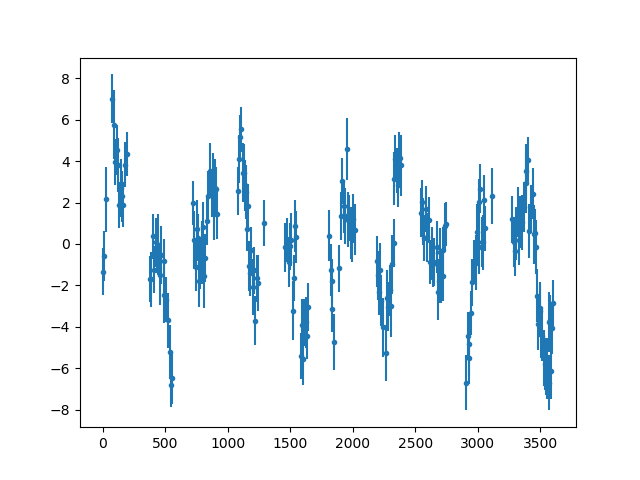

<ErrorbarContainer object of 3 artists>

In [17]:
plt.figure(fignum)
fignum += 1
plt.errorbar(times,sampled_data,sampled_errors,fmt=".")

## Exercise Two: Lomb-Scargle/Multiterm Periodogram

Implement the generalized Lomb-Scargle Periodigram from AstroML and the Multiterm Periodigram. The analysis of the data we want to do is similar to example figure 10.18. (http://www.astroml.org/book_figures/chapter10/fig_LS_double_eclipse.html#book-fig-chapter10-fig-ls-double-eclipse)
Is it possible to find the generating frequencies of the data? Write them down and let me know. 

Also, once this is done, change the random seed to None and play with the generating numerical values. How does this affect the ability of the periodogram to recover the underlying periods in the data?

## Generate Data to Use (Random Walk)

In [19]:
# Initial Values, these you can play with to see what happens to the analysis
delta_t = 10.0
max_time = 3600
times_RW = np.arange(0.0,max_time,delta_t)
noise_level = abs(npr.normal(loc=1,scale=0.125,size = len(times_RW)))
sampled_data_rw = generate_damped_RW(times_RW,tau=100, random_state=0)

<IPython.core.display.Javascript object>


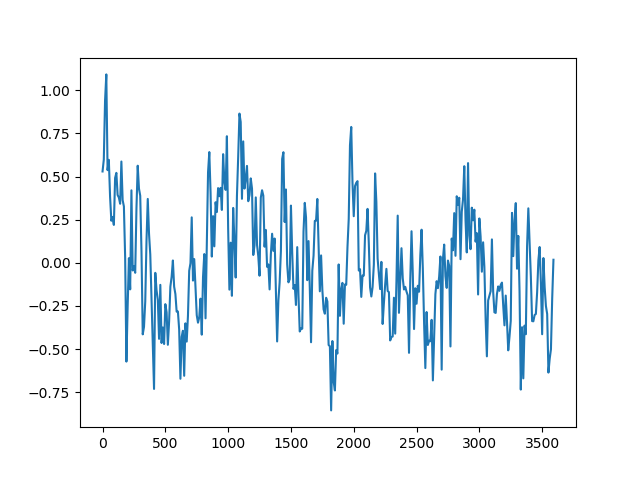

In [20]:
plt.figure(fignum)
fignum += 1
plt.plot(times_RW,sampled_data_rw)

## Exercise Three: Apply All Techniques to Random Walk